In [927]:
import h5py, json
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from rdkit import Chem
from rdkit.Chem import AllChem
import py3Dmol
from rdkit.Chem import rdGeometry
from rdkit.Chem import rdDetermineBonds
from itertools import combinations
import ira_mod
sofi = ira_mod.SOFI()

def load_atoms_and_coords_hdf5(fid=0, idx=42):
    """Load the atoms and coords of a single molecule from HDF5 file"""
    with h5py.File(molecule_files[fid], 'r') as f:
        # Get coordinates and reshape
        coords_flat = f['coords'][idx]
        coords = coords_flat.reshape(-1, 3)
        
        # Get atom types (decode bytes to string)
        atoms_str = f['atoms'][idx].decode('utf-8')
        atoms = atoms_str.split('|')
        
        return np.array(coords, dtype=float), atoms

def load_rings(fid=0):
    """Loads the informations about the rings from HDF5 file"""
    with h5py.File(feature_files[fid], "r") as f:
        rings_dset = f["rings"]
        ring_counts = f["nrings"][:]

        # Recover rings per molecule
        all_rings = []
        start = 0
        for count in ring_counts:
            rings = [rings_dset[i] for i in range(start, start + count)]
            all_rings.append(rings)
            start += count
            
    return ring_counts, all_rings

def analyze_rings(rings, coords):
    """Fits planes to all the rings using PCA and computes the angle between them"""
    coords = np.asarray(coords)
    normals, angles, abs_errors = [], [], []
    for ring in rings:
        centered = coords[ring] - np.mean(coords[ring], axis=0)
        cov = np.dot(centered.T, centered) / (coords.shape[0] - 1)
        eigvals, eigvecs = np.linalg.eigh(cov)

        # Get sort order (descending)
        idx = np.argsort(eigvals)[::-1]
        # Apply ordering
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:, idx]

        val = np.clip(eigvals[2], 0, None)
        abs_errors.append(np.sqrt(val).astype(np.float32))
        normals.append(eigvecs[:, 2])

    for i, j in combinations(range(len(normals)), 2):
        cos_theta = np.dot(normals[i], normals[j])
        # Clip to avoid numerical issues >1 or <−1
        cos_theta = np.clip(cos_theta, -1.0, 1.0)
        theta = np.arccos(abs(cos_theta))  # use abs to enforce "smaller of the two"
        angles.append((i, j, np.degrees(theta).astype(np.float32)))

    return normals, angles, abs_errors

def ring_planar_fits_and_angles(fid=0):
    """Computes how well planes fit rings in all the molecules and what are the angles between the planes"""
    ring_counts, all_rings = load_rings(fid)
    ring_non_planarities = []
    angles_between_rings = []
    with h5py.File(molecule_files[fid], 'r') as f:
        for i, c in enumerate(f['coords']):
            coords = np.array(c.reshape(-1, 3), dtype=float) # Coordinates as numpy array
            rings = all_rings[i]
            try:
                normals, angles, abs_errors = analyze_rings(rings, coords)
                ring_non_planarities.extend(abs_errors)
                angles_between_rings.extend(angles)
            except Exception as e:
                print(f"Ring planar fir for molecule {i} failed: {e}")
    return ring_non_planarities, angles_between_rings
                
def test_functions_on_a_molecule(fid=0, idx=42, sym_th="adaptive", s_growth=1.5e-2):
    """Computes and prints most of the SOFI symmetry and other geometry analysis outputs"""
    coords, atoms = load_atoms_and_coords_hdf5(fid, idx)
    nat = len(atoms)  # Number of atoms
    print(f"Structure has {nat} atoms")
    print(f"Atom types: {atoms}")
    
    # Map atom types to integers
    unique_atoms = list(set(atoms))
    atom_type_map = {atom: i+1 for i, atom in enumerate(sorted(unique_atoms))}
    print(f"Atom type mapping: {atom_type_map}")
    typ = np.array([atom_type_map[atom] for atom in atoms], dtype=int)
    
    # Set symmetry threshold - this determines how precisely atoms must match
    # after applying symmetry operations (typical values: 0.01-0.1)
    if sym_th == "adaptive":
        sym_thr = s_growth * nat # s_growth * np.sqrt((nat - 1) / 100)
    else:
        sym_thr = sym_th
    
    sym = sofi.compute(nat, typ, coords, sym_thr, origin=np.mean(coords, axis=0))
    
    # Print results
    print(f"Symmetry threshold used: {sym_th}")
    print(f"Point Group: {sym.pg}")
    print(f"Number of symmetry operations: {sym.n_sym}")
    print(f"Number of principal axes: {sym.n_prin_ax}")
    print(f"Principal axes:")
    for i, axis in enumerate(sym.prin_ax):
        print(f"  Axis {i+1}: [{axis[0]:.6f}, {axis[1]:.6f}, {axis[2]:.6f}]")
    
    print("\nSymmetry operations:")
    for i in range(sym.n_sym):
        op, n, p, axis, angle = sofi.analmat(sym.matrix[i])
        print(f"  {i+1}: {op}{n}^{p}, axis=[{axis[0]:.3f}, {axis[1]:.3f}, {axis[2]:.3f}], angle={angle:.3f}")
        
    print(f"Geometric center: {np.mean(coords, axis=0)}")
    print(f"\nHausdorff distances: {sym.dHausdorff}")
    
    # IMPORTANT: sofi.compute() does NOT automatically check for linearity!
    # We need to do this manually and correct the point group if needed
    is_collinear, linear_axis = sofi.check_collinear(nat, coords)
    if is_collinear:
        print(f"\n*** LINEAR MOLECULE DETECTED ***")
        print(f"Structure is linear along axis: [{linear_axis[0]:.3f}, {linear_axis[1]:.3f}, {linear_axis[2]:.3f}]")
        
        # Correct the point group for linear molecules
        if dim == "1D":
            sym.pg = "Cnv" # or "C∞v"
            print("Corrected Point Group: Cnv (linear molecule without inversion)")
        else:
            sym.pg = "Dnh" # or "D∞h" 
            print("Corrected Point Group: Dnh (linear molecule with inversion)")
    else:
        print(f"\nMolecule is not linear - point group {sym.pg} is correct")

    dim, abs_err, rel_err = molecular_dimensionality(coords)
    print(f"\nMolecule is {dim}\nStandard deviation out of line/plane: {abs_err:.3f} Å\nRelative non linearity/flatness: {rel_err:.1f}%")
                
    mirror_symmetry_count, chiral = symmetry_planes_and_chirality(dim, sym)
    print(f"\nThe molecule has {mirror_symmetry_count} vertical mirror plane(s)")
    if chiral:
        print(f"The molecule is chiral")
    else:
        print(f"The molecule is achiral")

    normals, angles, abs_errors = analyze_rings(all_rings[idx], coords)
    print(f"\nThe molecule is comprised of {len(normals)} rings:")
    for i, n in enumerate(normals):
        print(f"Normal of ring {i+1} {np.array2string(n, precision=2, suppress_small=True)}")
        print(f"Out of plane standard deviation of the ring: {abs_errors[i]:.2f} Å")
    for a in angles:
        print(f"The angle between ring {a[0]+1} and ring {a[1]+1} is {a[2]:.1f}°")

    visualize_molecule(fid, idx, text=False, rings=all_rings[idx], normals=normals, planes=True)

def symmetry_and_dimensionality_analysis_of_data(fid=0, sym_thr="adaptive", s_growth=1.5e-2):
    """Uses SOFI and PCA to find the point symmetry group, the dimension of molecule and vertical symmetry plane count"""
    point_groups = []
    dimensions = []
    mirror_symmetries = []
    chiralities = []

    with h5py.File(molecule_files[fid], 'r') as f:
        for i, a in enumerate(f['atoms']):
            coords_flat = f['coords'][i]
            coords = np.array(coords_flat.reshape(-1, 3), dtype=float) # Coordinates as numpy array
            atoms_str = a.decode('utf-8')
            atoms = atoms_str.split('|')
            nat = len(atoms)  # Number of atoms

            try:
                dim, a, e = molecular_dimensionality(coords)
                dimensions.append(dim)
            except Exception as e:
                dimensions.append("failed")
                print(f"Dimensional analysis for molecule {i} failed: {e}")
                
            if sym_thr == "adaptive":
                sym_thr = s_growth * nat # s_growth * np.sqrt((nat - 1) / 100)
            
            # Map atom types to integers
            unique_atoms = list(set(atoms))
            atom_type_map = {atom: i+1 for i, atom in enumerate(sorted(unique_atoms))}
            typ = np.array([atom_type_map[atom] for atom in atoms], dtype=int)
                
            try:
                sym = sofi.compute(nat, typ, coords, sym_thr, origin=np.mean(coords, axis=0))
                
                is_collinear, linear_axis = sofi.check_collinear(nat, coords)
                if dim == "1D":
                    # Correct the point group for linear molecules
                    if sym.n_sym == 1:
                        sym.pg = "Cnv"  # or "C∞v"
                    else:
                        sym.pg = "Dnh"  # or "D∞h"
                
                mirror_symmetry_count, chiral = symmetry_planes_and_chirality(dim, sym)
                if mirror_symmetry_count == -1:
                    sym.pg = "Cs"
                    mirror_symmetry_count += 1
                    
                point_groups.append(sym.pg)
                mirror_symmetries.append(mirror_symmetry_count)
                chiralities.append(chiral)
                
            except Exception as e:
                point_groups.append("failed")
                mirror_symmetries.append("failed")
                chiralities.append("failed")
                print(f"\nSymmetry analysis for molecule {i} failed: {e}")
                        
    return point_groups, dimensions, mirror_symmetries, chiralities

def molecular_dimensionality(coords, strict_precision=1E-3, almost_precision=1E-1):
    """Classifies molecules into: "1D", "almost 1D", "2D", "almost 2D", "3D" within specified tolerance using PCA"""
    coords = np.asarray(coords)
    centered = coords - np.mean(coords, axis=0)
    cov = np.dot(centered.T, centered) / (coords.shape[0] - 1)
    eigvals, eigvecs = np.linalg.eigh(cov)
    eigvals = np.sort(eigvals)[::-1]
    eigvals = np.clip(eigvals, 0, None)
    
    n = len(coords)
    frac_strict = 1 - strict_precision / n ** 0.5
    frac_almost = 1 - almost_precision / n ** 0.5
    
    fractions = eigvals / eigvals.sum()
    if fractions[0] > frac_strict:
        dim = "1D"
        abs_error = np.sqrt(eigvals[1] + eigvals[2])
        rel_error = (fractions[1] + fractions[2]) * 3/2 * 100
    elif fractions[0] > frac_almost:
        dim = "almost 1D"
        abs_error = np.sqrt(eigvals[1] + eigvals[2])
        rel_error = (fractions[1] + fractions[2]) * 3/2 * 100
    elif (fractions[0] + fractions[1]) > frac_strict:
        dim = "2D"
        abs_error = np.sqrt(eigvals[2])
        rel_error = fractions[2] * 3 * 100
    elif (fractions[0] + fractions[1]) > frac_almost:
        dim = "almost 2D"
        abs_error = np.sqrt(eigvals[2])
        rel_error = fractions[2] * 3 * 100
    else:
        dim = "3D"
        abs_error = np.sqrt(eigvals[2])
        rel_error = fractions[2] * 3 * 100
        
    return dim, abs_error, rel_error

def symmetry_planes_and_chirality(dim, sym, angle_prec=1E-3):
    """Returns the amount of NON-PLANAR symmetry planes and whether the molecule is GEOMETRICALLY chiral"""
    chiral = False
    mirror_symmetries = 0
    if dim == "1D":
        if sym.pg == "Dnh":
            mirror_symmetries += 1
    elif dim == "2D":
        mirror_symmetries -= 1
        for i in range(sym.n_sym):
            op, n, p, axis, angle = sofi.analmat(sym.matrix[i])
            # Check if it's a reflection (S operation with angle=0)
            if op == 'S' and abs(angle) < angle_prec:
                mirror_symmetries += 1
    else:
        chiral = True
        for i in range(sym.n_sym):
            op, n, p, axis, angle = sofi.analmat(sym.matrix[i])
            # If the molecule is symmetrical under S or I symmetry operations, it's non chiral
            if op == 'S':
                chiral = False
                if abs(angle) < angle_prec:
                    mirror_symmetries += 1
            elif op == "I":
                chiral = False

    return mirror_symmetries, chiral

def find_indices(lst, target="failed", inside=False):
    """Find indices of specific objects in a list"""
    if inside:
        return [i for i, val in enumerate(lst) if target in val]
    else:
        return [i for i, val in enumerate(lst) if target == val]

def find_indices_of_values_that_occur_n_times(lst, n=1):
    """Outputs indices of values that occur exactly n times"""
    counts = Counter(lst)
    # Find values that occur exactly n times
    unique_values = [val for val, count in counts.items() if count == n]
    # Get the indexes of these unique values
    unique_indexes = [i for i, val in enumerate(lst) if val in unique_values]

    return unique_indexes

def plot_attribute_distribution(attributes, xlabel, title, figsize=(8, 4), saveto="mol3d_data/plots/plot.png", save=False):
    """Plotting function to help visualize the distributions of molecule attrbutes"""
    counts = Counter(attributes)
    # Separate keys and values for plotting
    labels = list(counts.keys())
    values = list(counts.values())

    x = np.arange(len(labels))

    # Create a bar chart
    plt.figure(figsize=figsize) 
    plt.bar(x, values)
    plt.xticks(x, labels, rotation=90, fontsize=12)
    plt.xlabel(xlabel, fontsize=14)
    plt.yscale("log")
    plt.ylabel('Count', fontsize=14)
    plt.title(title, fontsize=16)
    if save:
        plt.savefig(saveto, bbox_inches='tight', dpi=300)
    plt.show()

def visualize_molecule(fid=0, idx=42, width=300, height=300, text=True, rings=None, normals=None, planes=False):
    """Outputs an interactive 3D model of a molecule"""
    coords, atoms = load_atoms_and_coords_hdf5(fid, idx)

    if text:
        print(f"Molecule is comprised of {len(atoms)} atoms:\n{atoms}")
        print(f"The coordinates are:\n{coords}")
        
    # Create editable molecule and add atoms
    molecule = Chem.RWMol()
    for atom in atoms:
        molecule.AddAtom(Chem.Atom(atom))

    # Add 3D conformer
    conf = Chem.Conformer(len(atoms))
    for i, (x, y, z) in enumerate(coords):
        conf.SetAtomPosition(i, rdGeometry.Point3D(float(x), float(y), float(z)))
    molecule.AddConformer(conf)

    # Figure out bonds
    try: rdDetermineBonds.DetermineBonds(molecule)
    except Exception as e: print(f"Bond generation failed: {e}")
    
    # Generate MOL block using RDKit’s built-in method to ensure proper 3D representation
    mol_block = Chem.MolToMolBlock(molecule)
    
    # Visualize interactively
    view = py3Dmol.view(width=width, height=height)
    view.addModel(mol_block, 'mol')
    view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'radius': 0.3}})

    if planes:
        for ring, normal in zip(rings, normals):
            ring_coords = coords[ring]
            centroid = ring_coords.mean(axis=0)
            start = centroid
            end = centroid + normal * 1.0  # scale arrow for visibility
        
            arrow = {
                'start': {'x': float(start[0]), 'y': float(start[1]), 'z': float(start[2])},
                'end':   {'x': float(end[0]),   'y': float(end[1]),   'z': float(end[2])},
                'color': 'red',
                'radius': 0.05
            }
            view.addArrow(arrow)
    
    view.zoomTo()
    view.show()

In [1105]:
molecule_files = ["mol3d_data/mol3d_mil1.h5",
                  "mol3d_data/mol3d_mil2.h5",
                  "mol3d_data/mol3d_mil3.h5",
                  "mol3d_data/mol3d_mil4.h5"]
feature_files = ["mol3d_data/mol3d_feat_mil1.h5",
                "mol3d_data/mol3d_feat_mil2.h5",
                "mol3d_data/mol3d_feat_mil3.h5",
                "mol3d_data/mol3d_feat_mil4.h5",]
fid = 3

In [26]:
ring_counts, all_rings = load_rings(fid)

In [137]:
n=-1

In [612]:
n += 1
sym = test_functions_on_a_molecule(fid, n)

Structure has 2 atoms
Atom types: ['B', 'Cl']
Atom type mapping: {'B': 1, 'Cl': 2}
Symmetry threshold used: adaptive
Point Group: C1
Number of symmetry operations: 1
Number of principal axes: 1
Principal axes:
  Axis 1: [1.000000, 0.000000, 0.000000]

Symmetry operations:
  1: E0^1, axis=[1.000, 0.000, 0.000], angle=0.000
Geometric center: [1.74590003 0.0416     0.079     ]

Hausdorff distances: [0.]

*** LINEAR MOLECULE DETECTED ***
Structure is linear along axis: [1.000, 0.000, 0.000]
Corrected Point Group: Cnv (linear molecule without inversion)

Molecule is 1D
Standard deviation out of line/plane: 0.000 Å
Relative non linearity/flatness: 0.0%

The molecule has 0 vertical mirror plane(s)
The molecule is achiral

The molecule is comprised of 0 rings:
Bond generation failed: Final molecular charge (0) does not match input (2); could not find valid bond ordering


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [1106]:
point_groups, dimensions, symmetry_planes, chiralities = symmetry_and_dimensionality_analysis_of_data(fid)


Symmetry analysis for molecule 716988 failed: nonzero error value obtained from libira_compute_all()
 %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
 ERROR: cannot set beta. Structure not properly shifted?
 %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
 small norm:  0.46499999999999997     
           4
 i=           1 j=           5
           4  0.37399999797344208      -0.17877499014139175      -0.27667498216032982     
           2 -0.92270000278949738       0.30412500351667404       0.47152503207325935     
           1  -1.1180999428033829       0.84122499078512192        1.3030249662697315     
           3   1.6667999476194382      -0.96657500416040421       -1.4978750161826611     
 origin at: /home/turih/IterativeRotationsAssignments/src/sofi_routines.f90 line:         454
 at: /home/turih/IterativeRotationsAssignments/src/sofi_routines.f90 line:         100
      ERROR FROM IRA/SOFI library ::: Cannot set beta basis!

Symmetry analysis for molecule 740608 failed: nonzero error value o

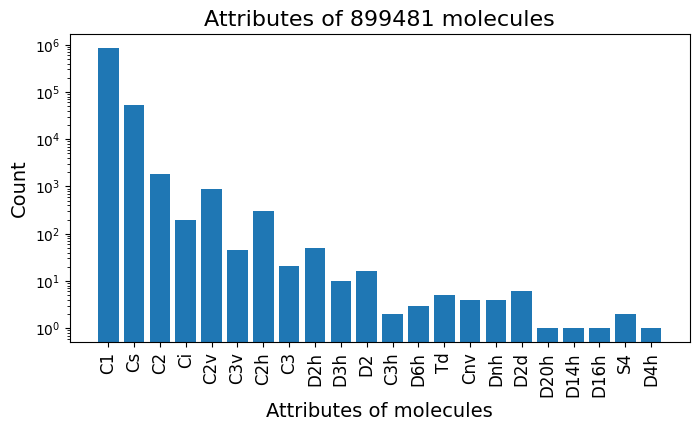

In [1166]:
plot_attribute_distribution(point_groups, 'Attributes of molecules', f'Attributes of {len(point_groups)} molecules')

In [1167]:
ind = find_indices(point_groups, "failed", inside=False)
print(len(ind))

0


In [1165]:
ind = find_indices_of_values_that_occur_n_times(point_groups, 3)
print(len(ind))

3


In [1157]:
n=-1

In [1162]:
n+=1
mid = ind[n]
visualize_molecule(fid, mid, text=False)
print(f"Molecule dimension: {dimensions[mid]}\nPoint group: {point_groups[mid]}\nNumber of vertical symmetry planes: {symmetry_planes[mid]}")
if chiralities[mid] == True: print("Molecule is geometrically chiral")
elif chiralities[mid] == False: print("Molecule is geometrically achiral")
else: print("Chirality determination failed")

# # dimensions[mid] = ""
# point_groups[mid] = "Cs"
# symmetry_planes[mid] = 0
# chiralities[mid] = False

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Molecule dimension: 2D
Point group: D6h
Number of vertical symmetry planes: 6
Molecule is geometrically achiral


In [1158]:
# dimensions[mid] = ""
point_groups[mid] = "Cs"
symmetry_planes[mid] = 1
chiralities[mid] = False

In [1168]:
with h5py.File(f"mol3d_data/mol3d_feat_mil{fid+1}.h5", "a") as f:
    print("Saving symmetry data...")
    # Save dimensions (strings)
    dt_str = h5py.string_dtype(encoding='utf-8')
    f.create_dataset("dimensions", data=np.array(dimensions, dtype=dt_str))

    # Save point groups (strings)
    f.create_dataset("point_groups", data=np.array(point_groups, dtype=dt_str))

    # Save symmetry_planes (integers)
    f.create_dataset("symmetry_planes", data=np.array(symmetry_planes, dtype=np.int32))

    # Save chiralities (booleans)
    f.create_dataset("chiralities", data=np.array(chiralities, dtype=np.bool_))
    print("All features saved successfully!")

Saving symmetry data...
All features saved successfully!


In [19]:
for fid in [1, 2, 3, 4]:
    ring_non_planarities, angles_between_rings = ring_planar_fits_and_angles(molecule_files[fid-1], feature_files[fid-1])
    with h5py.File(f"mol3d_data/mol3d_feat_mil{fid}.h5", "a") as f:
        print("Saving ring planar features...")
        ring_non_planarities = np.array(ring_non_planarities, dtype=np.float32)
        f.create_dataset("errors", data=ring_non_planarities)
        # Define compound dtype: two int32s + one float32
        angles_dtype = np.dtype([("i", np.int32), ("j", np.int32), ("val", np.float32)])
    
        # Convert to structured array
        angles_arr = np.array(angles_between_rings, dtype=angles_dtype)
        f.create_dataset("plane_angles", data=angles_arr)

Saving ring planar features...
Saving ring planar features...
Saving ring planar features...
